# The Water Challenge: The Evian Round (R)

- draft version 1
- part 1 of a planned 7-part project (*see* **Project outline**)
- **R** version; *see* [**Github** folder](https://github.com/tros01/projects) for the **Python** version
- *see* **Notes and reference material** for links to research notes and references
- *see* **Playlist** for the soundtrack
- [**contact me via LinkedIn**](https://www.linkedin.com/in/tomas-rosecky-uk/)

## Experiment summary

Suspended.

## Data and workings

In [1]:
# Libraries
library(tidyverse)
library(readxl)
library(cmdstanr)
library(posterior)

# Session seed
set.seed(101)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is cmdstanr version 0.9.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: C:/Users/rosec/.cmdstan/cmdstan-2.37.0

- CmdStan version: 2.37.0

This is posterior version 1.6.1


Attaching package: 'posterior'


The following objects are masked from 'package:stats':

    mad, sd, var


The following objects are masked from 'package:base':

    %in%, match




In [2]:
# Commons
root_folder <- r"(D:\data_save\h20_round1)"

### Sampling

We have generated two vectors with values B (for a black can) and G (for a green can). These two vectors of pseudorandom values have dictated the order in which samples have been handed out to participants in two separate cohorts.

Below, we check the path of each vector as a random walk. For each sample B we subtract 1; for each sample G we add 1 and cumulate the path of the draws. We report the summary statistics (mean and variance) for each vector. Lastly, we validate the randomness of draws in each vector.

In [3]:
# Order vector
outcome_vector <- c("B", "G")
seq_size <- 45

```R
sample_df1 <- tibble(
    sampling_order_a = seq(seq_size),
    sample_a = sample(outcome_vector, seq_size, replace = TRUE, prob = c(rep(1 / length(outcome_vector), length(outcome_vector))))
) |>
    mutate(
        sampling_order_b = sampling_order_a + seq_size,
        sample_b = sample(outcome_vector, seq_size, replace = TRUE, prob = c(rep(1 / length(outcome_vector), length(outcome_vector))))
    )
sample_df1 |> head(n=10)

sample_df2 <- tibble(
    sampling_order_c = seq(seq_size),
    sample_c = sample(outcome_vector, seq_size, replace = TRUE, prob = c(rep(1 / length(outcome_vector), length(outcome_vector))))
) |>
    mutate(
        sampling_order_d = sampling_order_c + seq_size,
        sample_d = sample(outcome_vector, seq_size, replace = TRUE, prob = c(rep(1 / length(outcome_vector), length(outcome_vector))))
    )
sample_df2 |> head(n=10)
```

In [4]:
sample_df1 <- suppressMessages(
    read_excel(
        file.path(root_folder, "sample_vector1.xlsx"),
        skip = 1,
        col_names = FALSE
    )
)

cat("\n#### Sample vector 1:\n")
sample_df1 |> head()


#### Sample vector 1:


...1,...2,...3,...4
<dbl>,<chr>,<dbl>,<chr>
1,B,46,B
2,B,47,B
3,G,48,B
4,B,49,B
5,B,50,B
6,G,51,B


In [5]:
sample_df2 <- suppressMessages(
    read_excel(
        file.path(root_folder, "sample_vector2.xlsx"),
        skip = 1,
        col_names = FALSE
    )
)

cat("\n#### Sample vector 2:\n")
sample_df2 |> head()


#### Sample vector 2:


...1,...2,...3,...4
<dbl>,<chr>,<dbl>,<chr>
1,G,46,G
2,G,47,B
3,B,48,B
4,B,49,G
5,B,50,B
6,B,51,B


In [6]:
# Bind the vectors and data frames, recode values
sampling_draws <- suppressMessages(
        tibble(
        sample_order = c(sample_df1[[1]], sample_df1[[3]]),
        vector1 = c(sample_df1[[2]], sample_df1[[4]]),
        vector2 = c(sample_df2[[2]], sample_df2[[4]])
    )
) |>
    mutate(
        across(
            c(vector1, vector2),
            ~ case_match(
                .x,
                "B" ~ -1,
                "G" ~ 1,
                .default = NA_real_
            )
        )
    )

# Cumulate the draws and pivot the cumulated columns
sampling_draws_long <- sampling_draws |>
    mutate(
        vec1_cumsum = cumsum(vector1),
        vec2_cumsum = cumsum(vector2)
    ) |>
    pivot_longer(
        cols = ends_with("cumsum"),
        names_to = "var",
        values_to = "val"
    )

cat("\n#### Recoded vector of sample draws:\n")
sampling_draws |> head(n=10)


#### Recoded vector of sample draws:


sample_order,vector1,vector2
<dbl>,<dbl>,<dbl>
1,-1,1
2,-1,1
3,1,-1
4,-1,-1
5,-1,-1
6,1,-1
7,1,-1
8,1,-1
9,-1,1



#### Figure 1: First round sampling orders:


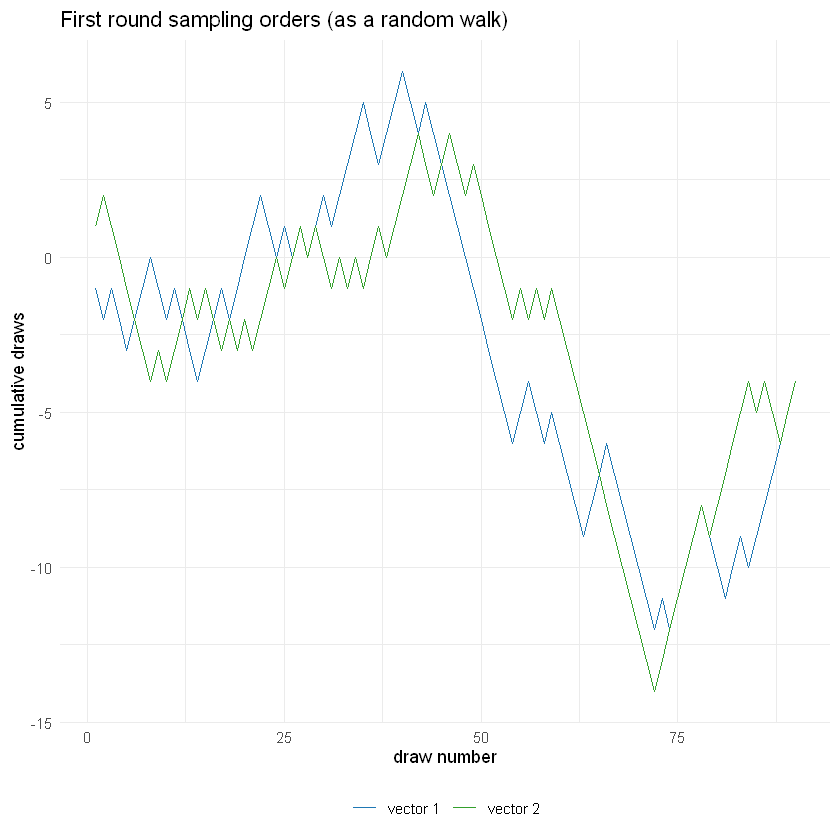

In [7]:
cat("\n#### Figure 1: First round sampling orders:\n")
ggplot(sampling_draws_long, aes(x = sample_order, y = val, color = var)) +
    geom_line() +
    theme_minimal() +
    theme(legend.position = "bottom") +
    labs(
        x = "draw number",
        y = "cumulative draws",
        color = NULL,
        title = "First round sampling orders (as a random walk)"
    ) +
    scale_color_manual(
        values = c(vec1_cumsum = "#1f78b4", vec2_cumsum = "#33a02c"),
        labels = c(vec1_cumsum = "vector 1", vec2_cumsum = "vector 2")

    )

In [8]:
# Compute descriptive statistics
sampling_vector_summary_stats <- tibble(
    stat = c("vector1", "vector2"),
    mean = c(
        mean(sampling_draws$vector1),
        mean(sampling_draws$vector2)
    ),
    variance = c(
        var(sampling_draws$vector1),
        var(sampling_draws$vector2)
    )
) 

cat("\n#### Mean and variance of the sampling vectors:\n")
sampling_vector_summary_stats |> print()


#### Mean and variance of the sampling vectors:
# A tibble: 2 × 3
  stat       mean variance
  <chr>     <dbl>    <dbl>
1 vector1 -0.0444     1.01
2 vector2 -0.0444     1.01


In [9]:
# Validate the randomness
    # Vector identity

cat("\n#### Are the vectors identical?\n")
identical(sampling_draws$vector1, sampling_draws$vector2)


#### Are the vectors identical?


[1] FALSE

In [10]:
    # Proportion of identical elements

cat("\n#### What is the proportion of identical elements?\n")
sum(sampling_draws$vector1 == sampling_draws$vector2, na.rm = TRUE) / 
    sum(!is.na(sampling_draws$vector1))


#### What is the proportion of identical elements?


[1] 0.5333333

In [11]:
    # Probability the means are equal
n <- nrow(sampling_draws)
theta <- 1 / length(outcome_vector)

cat("\n#### What is the probability the means will be identical?\n")
sum(dbinom(seq(0,n), n, theta)^2)


#### What is the probability the means will be identical?


[1] 0.05938826

### Data

In [12]:
# Extract col names
header <- suppressMessages(
    read_excel(
        file.path(root_folder, "id_df.xlsx"),
        sheet = "round1a",
        skip = 1,
        col_names = FALSE,
        col_types = NULL
    ) |> slice(1) |> as.vector()
)

In [13]:
# Table cohort 1
df1 <- suppressMessages(
    read_excel(
        file.path(root_folder, "id_df.xlsx"),
        sheet = "round1a",
        skip = 3,
        col_names = FALSE,
        col_types = NULL
    )
)

colnames(df1) <- header

In [14]:
# Table cohort 2
df2 <- suppressMessages(
    read_excel(
        file.path(root_folder, "id_df.xlsx"),
        sheet = "round1b",
        skip = 3,
        col_names = FALSE,
        col_types = NULL
    )
)

colnames(df2) <- header

#### Clean dataset

In [15]:
# Splice, clean and recode the main df; add matches
df <- bind_rows(df1, df2) |>
    select(-name) |>
    filter(!is.na(sample)) |>
    mutate(
        sample = case_match(
            sample,
            "G" ~ 1,
            "B" ~ 0,
            .default = NA_real_
        ),
        guess = case_match(
            guess,
            "P" ~ 1,
            "T" ~ 0,
            .default = NA_real_
        ),
        match = as.numeric(sample == guess),
        round_brand = case_match(
            sample,
            1 ~ "evian",
            0 ~ "tap",
            .default = NA_character_
        ),
        round = 1
    ) |>
    relocate(match, .after = guess)

cat("\n#### Clean dataset:\n")
df |> print()


#### Clean dataset:
# A tibble: 30 × 9
   ID     sample guess match confidence batch cup   round_brand round
   <chr>   <dbl> <dbl> <dbl>      <dbl> <dbl> <chr> <chr>       <dbl>
 1 ID0001      1     1     1       0.92     1 mug   evian           1
 2 ID0002      1     1     1       0.95     1 mug   evian           1
 3 ID0003      0     0     1       0.8      1 glass tap             1
 4 ID0004      0     0     1       1        1 glass tap             1
 5 ID0005      0     1     0       0.8      1 glass tap             1
 6 ID0006      0     1     0       0.8      1 glass tap             1
 7 ID0007      0     0     1       0.75     1 glass tap             1
 8 ID0008      0     0     1       0.9      2 glass tap             1
 9 ID0009      1     0     0       1        2 glass evian           1
10 ID0010      0     1     0       0.75     2 mug   tap             1
# ℹ 20 more rows


#### Contingency table

In [16]:
contingency_table <- tibble(
    # Sample {potted, tap}
    group = c("sample_p", "sample_t"),
    # Guess potted
    guess_p = c(
        # True positives
        sum((df$sample == 1) & (df$guess == 1)),
        # False positives
        sum((df$sample == 0) & (df$guess == 1))
    ),
    # Guess tap
    guess_t = c(
        # False negatives
        sum((df$sample == 1) & (df$guess == 0)),
        # True negatives
        sum((df$sample == 0) & (df$guess == 0))
    )
)

cat("\n#### Contingency table (counts):\n")
contingency_table |> print()


#### Contingency table (counts):
# A tibble: 2 × 3
  group    guess_p guess_t
  <chr>      <int>   <int>
1 sample_p       6       9
2 sample_t       5      10


In [17]:
# Frequentist CT
fct <- as.matrix(contingency_table[,2:3])

# Bayesian CT
bct <- as.matrix(contingency_table[,2:3])

In [18]:
# Pie chart data
pc_df <- contingency_table |>
    pivot_longer(
        cols = starts_with("guess"),
        names_to = "var",
        values_to = "val"
    ) |>
    mutate(
        # Proportions
        pc = val / sum(val),
        # Construct factor levels
        case_order = case_when(
            group == "sample_p" & var == "guess_p" ~ 1L,
            group == "sample_p" & var == "guess_t" ~ 2L,
            group == "sample_t" & var == "guess_t" ~ 3L,
            group == "sample_t" & var == "guess_p" ~ 4L
        ),
        description = case_when(
            # True positives
            group == "sample_p" & var == "guess_p" ~ paste0(round(pc * 100, 2), "% tasted Evian and got it right!"),
            # False negatives
            group == "sample_p" & var == "guess_t" ~ paste0(round(pc * 100, 2), "% tasted Evian and got it wrong..."),
            # True negatives
            group == "sample_t" & var == "guess_t" ~ paste0(round(pc * 100, 2), "% tasted London tap water and got it right!"),
            # False positives
            group == "sample_t" & var == "guess_p" ~ paste0(round(pc * 100, 2), "% tasted London tap water and got it wrong...")
        ),
        # Assign factor levels to descriptors
        description = factor(
            description,
            levels = description[order(case_order)]
        )
    )

# Colour scheme
legend_cols <- c(
    # True positives
    "#8FD694",
    # False negatives
    "#C7A9CF",
    # True negatives
    "#A7C6ED",
    # False negatives
    "#F7A8A6"
)

pc_df |> print()

# A tibble: 4 × 6
  group    var       val    pc case_order description                           
  <chr>    <chr>   <int> <dbl>      <int> <fct>                                 
1 sample_p guess_p     6 0.2            1 20% tasted Evian and got it right!    
2 sample_p guess_t     9 0.3            2 30% tasted Evian and got it wrong...  
3 sample_t guess_p     5 0.167          4 16.67% tasted London tap water and go…
4 sample_t guess_t    10 0.333          3 33.33% tasted London tap water and go…


Saving 6.67 x 6.67 in image


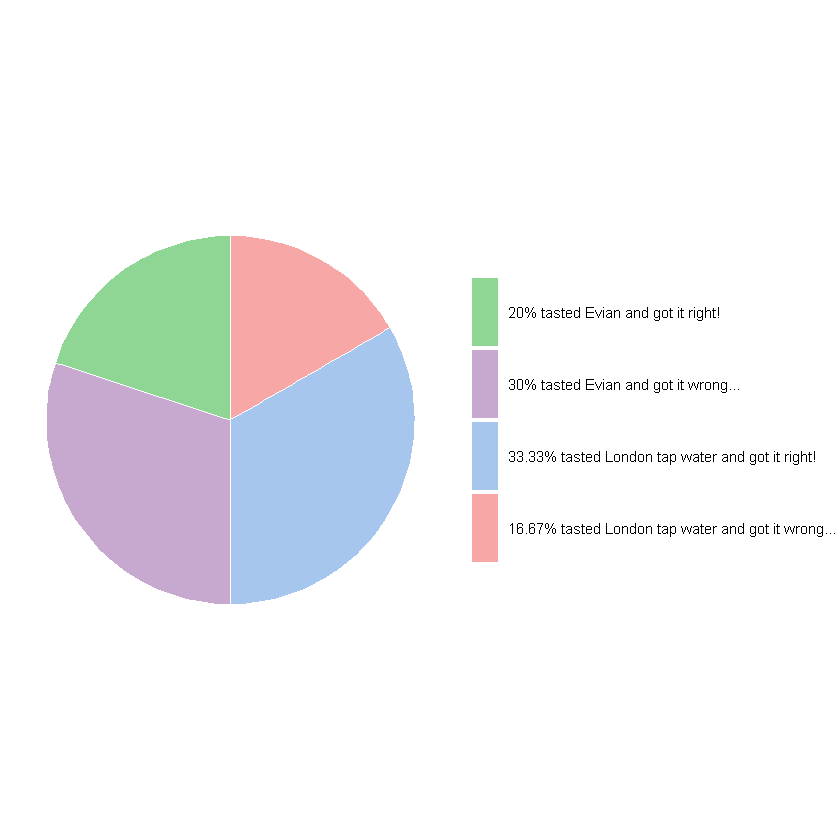

In [19]:
# Pie chart
ggplot(pc_df, aes(x = "", y = pc, fill = description)) +
    geom_bar(stat = "identity", width = 1, color = "white") +
    coord_polar("y", start = 0) +
    theme_void() +
    theme(
        legend.position   = "right",
        legend.key.height = unit(3, "line")
    ) +
    guides(fill = guide_legend(nrow = 4)) +
    scale_fill_manual(values = legend_cols) +
    labs(fill = NULL)
ggsave("pc_graph.png", dpi = 600)

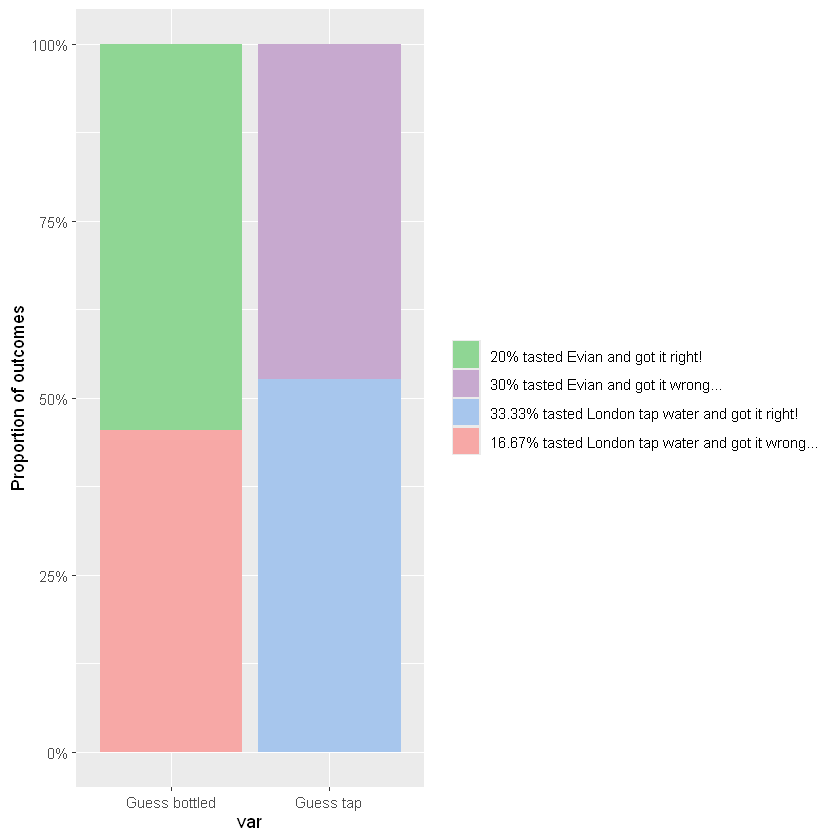

In [20]:
ggplot(pc_df, aes(x = var, y = val, fill = description)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_x_discrete(
      labels = c(
          "guess_p" = "Guess bottled",
          "guess_t" = "Guess tap"
      )
  ) +
  scale_fill_manual(values = legend_cols) +
  labs(
      y = "Proportion of outcomes",
      fill = NULL
  )

### Frequentist analysis

In [21]:
# Critical value
p <- 0.05
cv <- qnorm(1 - p / 2)

In [22]:
# Haldane-Anscombe correction
if (any(fct == 0)) {
    fct <- fct + 0.5
}

# Probability of a true positive
fp1 <- fct[1,1] / sum(fct[1,], na.rm=TRUE)

# Probability of a false negative
fp2 <- fct[2,1] / sum(fct[2,], na.rm=TRUE)

In [23]:
# Risk ratio
rho_hat <- fp1 / fp2
    # Standard errors
se_ln_rho <- sqrt(
    (1 / fct[1,1]) - (1 / sum(fct[1,], na.rm=TRUE)) + (1 / fct[2,1]) - (1 / sum(fct[2,], na.rm=TRUE))
)
    # Confidence intervals
ci_rho <- c(
    exp(log(rho_hat) - cv * se_ln_rho),
    exp(log(rho_hat) + cv * se_ln_rho)
)

# Odds ratio
theta_hat <- (fp1 / (1 - fp1)) / (fp2 / (1 - fp2))
    # Standard errors
se_ln_theta <- sqrt(
    sum(sapply(
        as.vector(fct),
        \(x) (1 / x)
    ))
)
    # Confidence intervals
ci_theta <- c(
    exp(log(theta_hat) - cv * se_ln_theta),
    exp(log(theta_hat) + cv * se_ln_theta)
)

In [24]:
# Results df
fdf <- tibble(
    # Frequentist estimates
    p1 = round(fp1, 3), p2 = round(fp2, 3),
    # Risk ratio estimate (effect size)
    risk_ratio = round(rho_hat, 3),
    # 95 pc confidence intervals
    rr_ci_lo = round(ci_rho[1], 3), rr_ci_hi = round(ci_rho[2], 3),
    # Risk ratio significance
    rr_significance = ifelse(
        (ci_rho[1] > 1) | (ci_rho[2] < 1),
        "**", "-"
    ),
    # Odds ratio estimate (effect size)
    odds_ratio = round(theta_hat, 3),
    # 95pc confidence intervals
    or_ci_lo = round(ci_theta[1], 3), or_ci_hi = round(ci_theta[2], 3),
    # Odds ratio significance
    or_significance = ifelse(
        (ci_theta[1] > 1) | (ci_theta[2] < 1),
        "**", "-"
    )
)

cat("\n#### Frequentist estimates, risk and odds ratios:\n")
fdf |> head()


#### Frequentist estimates, risk and odds ratios:


p1,p2,risk_ratio,rr_ci_lo,rr_ci_hi,rr_significance,odds_ratio,or_ci_lo,or_ci_hi,or_significance
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
0.4,0.333,1.2,0.466,3.093,-,1.333,0.301,5.915,-


### Bayesian analysis

In [25]:
# Stan script
stan_script <- "
data {
    int K; // {treatment, control}
    array[K] int n; // Trials per group
    array[K] int y; // Successes per group
}
parameters {
    vector<lower=0, upper=1>[K] p;
}
model {
    // Jeffreys prior
    p ~ beta(0.5, 0.5);

    // Binomial likelihood
    y ~ binomial(n, p);
}
generated quantities {
    real risk_ratio = p[1] / p[2];
    real odds_ratio = (p[1] / (1 - p[1])) / (p[2] / (1 - p[2]));
}
"

# Write the Stan model into a file
stan_file <- write_stan_file(stan_script)

# Compile the model
mod <- cmdstan_model(stan_file)

In [26]:
# Stan data
stan_data <- list(
    K = 2, # {treatment, control}
    n = as.integer(c(sum(bct[1, ]), sum(bct[2, ]))), # Trials per group
    y = as.integer(c(bct[1, 1], bct[2, 1])) # Successes per group
)

cat("\n#### Stan data check:\n")
print(stan_data)


#### Stan data check:
$K
[1] 2

$n
[1] 15 15

$y
[1] 6 5



In [27]:
# Sample
fit <- mod$sample(
    data = stan_data,
    chains = 6, 
    parallel_chains = 6,
    iter_warmup = 4e2L, # 4e3L
    iter_sampling = 16e2L, # 16e3L
    seed = 42,
    refresh = 0, # Suppress progress updates
    show_messages = FALSE # Suppress Stan messages
)

In [28]:
# Sampling diagnostics
fit_summary <- fit$summary()

cat("\n#### Summary and diagnostics:\n")
print(fit_summary)


#### Summary and diagnostics:
# A tibble: 5 × 10
  variable      mean  median    sd   mad      q5     q95  rhat ess_bulk ess_tail
  <chr>        <dbl>   <dbl> <dbl> <dbl>   <dbl>   <dbl> <dbl>    <dbl>    <dbl>
1 lp__       -22.1   -21.8   1.01  0.738 -24.2   -21.2    1.00    4322.    5502.
2 p[1]         0.403   0.398 0.119 0.120   0.212   0.612  1.00    9102.    6297.
3 p[2]         0.346   0.339 0.114 0.118   0.169   0.546  1.00    7909.    6421.
4 risk_ratio   1.33    1.17  0.702 0.532   0.547   2.62   1.00    8355.    6728.
5 odds_ratio   1.73    1.29  1.49  0.909   0.385   4.52   1.00    8603.    6551.


In [29]:
# Posterior summaries
draws_mat <- as_draws_matrix(fit$draws(c("p[1]","p[2]","risk_ratio","odds_ratio")))

# Quantiles (credible bands)
rr_q <- quantile(draws_mat[, "risk_ratio"], probs = c(0.025, 0.5, 0.975))
or_q <- quantile(draws_mat[, "odds_ratio"], probs = c(0.025, 0.5, 0.975))

In [30]:
# Results df
bdf <- tibble(
    # Bayesian estimates
    p1 = round(median(draws_mat[, "p[1]"]), 3), p2 = round(median(draws_mat[, "p[2]"]), 3),
    # Risk ratio estimate (effect size)
    risk_ratio = round(median(draws_mat[, "risk_ratio"]), 3),
    # 95pc credible bands
    rr_cb_lo = round(rr_q[1], 3), rr_cb_hi = round(rr_q[3], 3),
    # Risk ratio significance
    rr_significance = ifelse(
        (rr_q[1] > 1) | (rr_q[3] < 1), 
        "**", "-"
    ),
    # Odds ratio estimate (effect size)
    odds_ratio = round(median(draws_mat[, "odds_ratio"]), 3),
    # 95pc credible bands
    or_cb_lo = round(or_q[1], 3), or_cb_hi = round(or_q[3], 3),
    # Odds ratio significance
    or_significance = ifelse(
        (or_q[1] > 1) | (or_q[3] < 1), 
        "**", "-"
    )
)

cat("\n#### Bayesian estimates, risk and odds ratios:\n")
bdf |> head()


#### Bayesian estimates, risk and odds ratios:


p1,p2,risk_ratio,rr_cb_lo,rr_cb_hi,rr_significance,odds_ratio,or_cb_lo,or_cb_hi,or_significance
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
0.398,0.339,1.171,0.465,3.152,-,1.292,0.303,5.812,-


## Dot-and-errorbar plots

In [31]:
# Risk plot
    # Stan model quantiles
q1 <- quantile(draws_mat[, "p[1]"], probs = c(0.025, 0.5, 0.975))
q2 <- quantile(draws_mat[, "p[2]"], probs = c(0.025, 0.5, 0.975))

    # Estimate df
estimates_df <- bind_rows(
    fdf |> 
        # Select the proportion estimates
        select(starts_with("p")) |>
        pivot_longer(
            cols = everything(),
            names_to = "parameter",
            values_to = "estimate"
        ) |>
        mutate(
            # Wald CIs
            lower_bound = estimate - (cv * sqrt(estimate * (1 - estimate) / n)),
            upper_bound = estimate + (cv * sqrt(estimate * (1 - estimate) / n)),
            method = paste0(parameter, " (frequentist)")
        ),
    bdf |> 
        # Select the proportion estimates
        select(starts_with("p")) |>
        pivot_longer(
            cols = everything(),
            names_to = "parameter",
            values_to = "estimate"
        ) |>
        mutate(
            # Credible bands
            lower_bound = c(q1[1], q2[1]),
            upper_bound = c(q1[3], q2[3]),
            method = paste0(parameter, " (Bayesian)")
        )
)

estimates_df

parameter,estimate,lower_bound,upper_bound,method
<chr>,<dbl>,<dbl>,<dbl>,<chr>
p1,0.400,0.2987879,0.5012121,p1 (frequentist)
p2,0.333,0.2356330,0.4303670,p2 (frequentist)
p1,0.398,0.1851072,0.6450212,p1 (Bayesian)
p2,0.339,0.1455100,0.5837716,p2 (Bayesian)


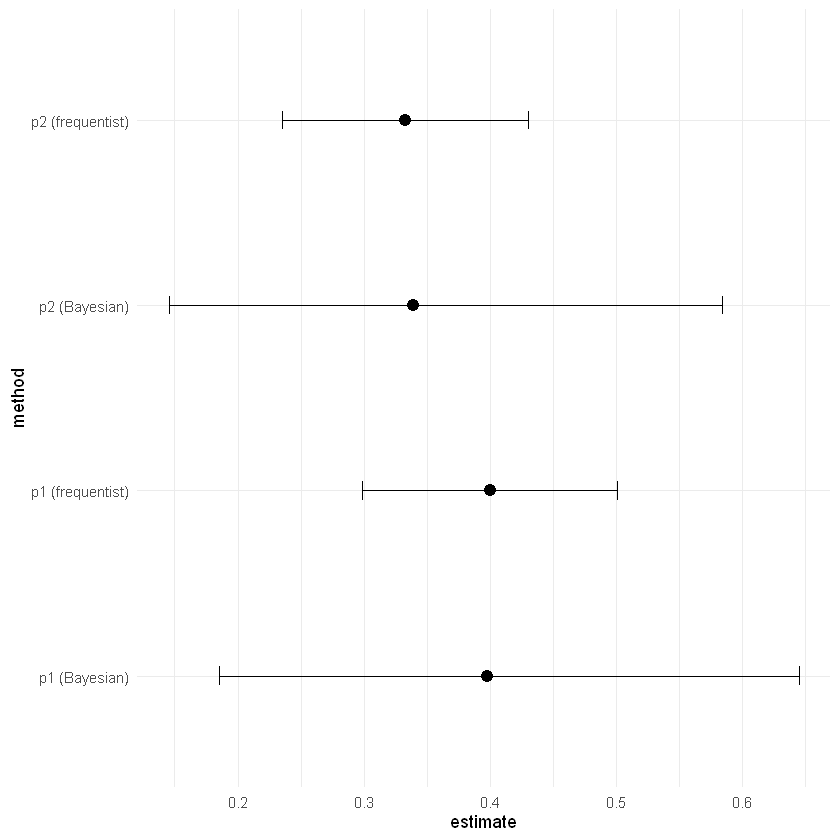

In [32]:
# Estimate plot
ggplot(estimates_df, aes(method, estimate)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_bound, ymax = upper_bound), width = 0.1) +
    theme_minimal() +
    coord_flip()

In [33]:
# Average estimates
avg_estimates <- estimates_df |> 
    group_by(parameter) |> 
    summarise(avg_estimate = mean(estimate), .groups="drop") |>
    print()

# A tibble: 2 × 2
  parameter avg_estimate
  <chr>            <dbl>
1 p1               0.399
2 p2               0.336


In [34]:
# Ratios df
fdf_renamed <- fdf |> 
    # Rename the variables for easier pivoting
    select(-c(ends_with("significance"), starts_with("p"))) |>
    rename_with(~str_replace(.x, "rr_[a-z]{2}", "risk"), starts_with("rr")) |>
    rename_with(~str_replace(.x, "or_[a-z]{2}", "odds"), starts_with("or")) |>
    pivot_longer(
        cols = everything(),
        names_to = c("measure", ".value"),
        names_pattern = "^(.*)_(ratio|lo|hi)$"
    ) |>
    rename(
        estimate = ratio,
        lower_bound = lo,
        upper_bound = hi,
        ratio = measure
    ) |>
    mutate(
        method = paste0(ratio, " ratio (frequentist)")
    )

bdf_renamed <- bdf |> 
    # Rename the variables for easier pivoting
    select(-c(ends_with("significance"), starts_with("p"))) |>
    rename_with(~str_replace(.x, "rr_[a-z]{2}", "risk"), starts_with("rr")) |>
    rename_with(~str_replace(.x, "or_[a-z]{2}", "odds"), starts_with("or")) |>
    pivot_longer(
        cols = everything(),
        names_to = c("measure", ".value"),
        names_pattern = "^(.*)_(ratio|lo|hi)$"
    ) |>
    rename(
        estimate = ratio,
        lower_bound = lo,
        upper_bound = hi,
        ratio = measure
    ) |>
    mutate(
        method = paste0(ratio, " ratio (Bayesian)")
    )

ratios_df <- bind_rows(
    fdf_renamed,
    bdf_renamed
)

ratios_df

ratio,estimate,lower_bound,upper_bound,method
<chr>,<dbl>,<dbl>,<dbl>,<chr>
risk,1.200,0.466,3.093,risk ratio (frequentist)
odds,1.333,0.301,5.915,odds ratio (frequentist)
risk,1.171,0.465,3.152,risk ratio (Bayesian)
odds,1.292,0.303,5.812,odds ratio (Bayesian)


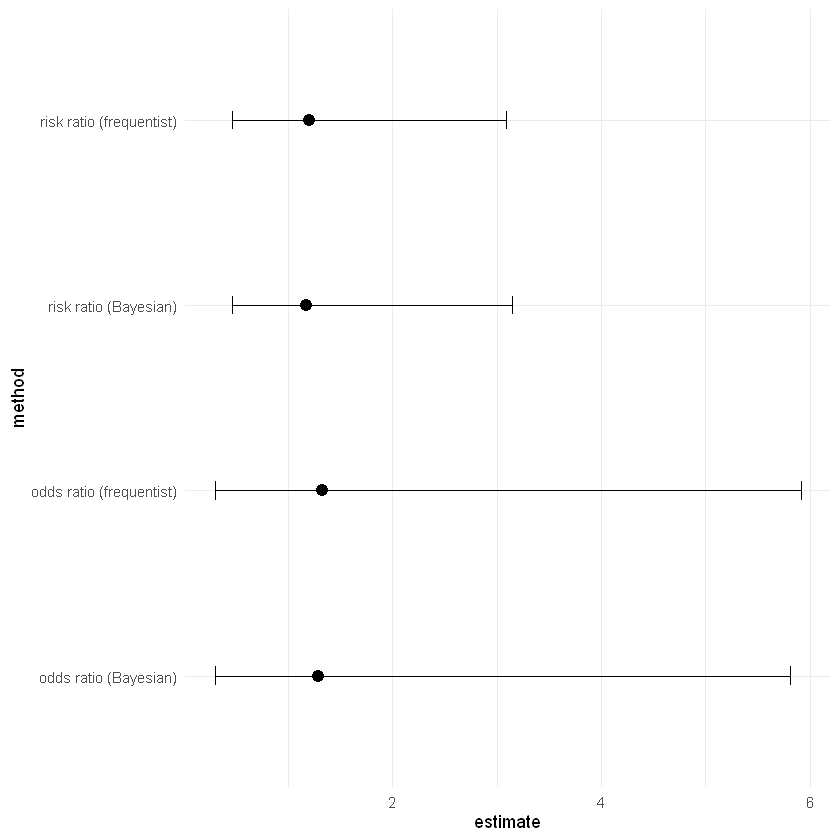

In [35]:
# Ratios plot
ggplot(ratios_df, aes(method, estimate)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_bound, ymax = upper_bound), width = 0.1) +
    theme_minimal() +
    coord_flip()

In [36]:
# Average ratios
avg_ratios <- ratios_df |> 
    group_by(ratio) |> 
    summarise(avg_ratio = mean(estimate), .groups="drop") |>
    print()

# A tibble: 2 × 2
  ratio avg_ratio
  <chr>     <dbl>
1 odds       1.31
2 risk       1.19


### Modified Brier score

In [37]:
# Subset the main df, compute the first-round modified Brier score and the inverse adjusted accuracy score
bs_df <- df |>
    select(ID, match, confidence) |>
    group_by(ID) |>
    summarise(
        mb_score = mean((confidence - match)^2),
        .groups = "drop"
    ) |>
    mutate(
        rank_score = 1 - mb_score
    ) |>
    arrange(desc(rank_score))

bs_df |> print(n=Inf)

# A tibble: 30 × 3
   ID     mb_score rank_score
   <chr>     <dbl>      <dbl>
 1 ID0004  0           1     
 2 ID0011  0           1     
 3 ID0015  0           1     
 4 ID0021  0           1     
 5 ID0024  0           1     
 6 ID0002  0.00250     0.997 
 7 ID0001  0.00640     0.994 
 8 ID0008  0.0100      0.99  
 9 ID0022  0.0100      0.99  
10 ID0003  0.0400      0.96  
11 ID0019  0.0400      0.96  
12 ID0007  0.0625      0.938 
13 ID0025  0.09        0.91  
14 ID0028  0.16        0.84  
15 ID0099  0.16        0.84  
16 ID0012  0.25        0.75  
17 ID0016  0.25        0.75  
18 ID0017  0.25        0.75  
19 ID0023  0.25        0.75  
20 ID0026  0.25        0.75  
21 ID0029  0.36        0.64  
22 ID0020  0.49        0.51  
23 ID0010  0.562       0.438 
24 ID0005  0.64        0.36  
25 ID0006  0.64        0.36  
26 ID0014  0.64        0.36  
27 ID0018  0.980       0.0199
28 ID0009  1           0     
29 ID0027  1           0     
30 ID0100  1           0     


In [38]:
# Construct a ranking table
name_df <- bind_rows(df1, df2) |>
    select(ID, name) |>
    filter(!is.na(name))

bs_ranking <- bs_df |>
    left_join(name_df, by="ID") |>
    left_join(
        df |> select(ID, sample, match),
        by="ID"
    ) |> 
    filter(
        as.numeric(str_extract(ID, "\\d+")) <= 50
    ) |>
    mutate(
        rank = seq(n()),
        sample = case_match(
            sample,
            0 ~ "London tap water",
            1 ~ "Evian",
            .default = NA_character_
        ),
        match = case_match(
            match,
            0 ~ ":(",
            1 ~ ":)",
            .default = NA_character_
        )
    ) |>
    select(rank, name, sample, match, rank_score) # |> print(n = Inf)

## Save required data

In [39]:
# Save cleaned data
write_csv(
    df,
    file.path(root_folder, "round1_df.csv")
)

# Save ranking data
write_csv(
    bs_ranking,
    file.path(root_folder, "round1_ranking.csv")
)